In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import Data

In [2]:
data = pd.read_csv("conversion_data.csv")
data

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0
...,...,...,...,...,...,...
316195,US,26,1,Ads,9,0
316196,US,27,1,Direct,6,0
316197,China,25,0,Ads,4,0
316198,US,22,0,Seo,4,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


# Data Overview

                                             |                                             | [  0%]   00:00 ->…


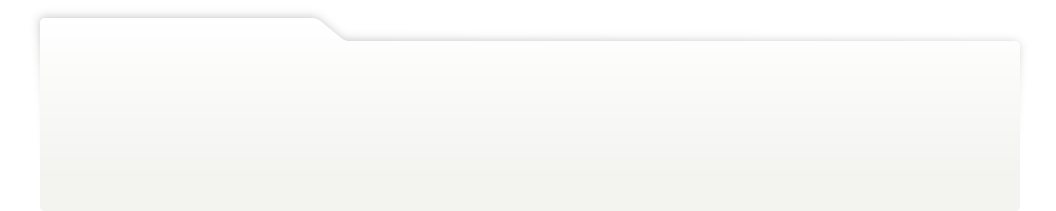
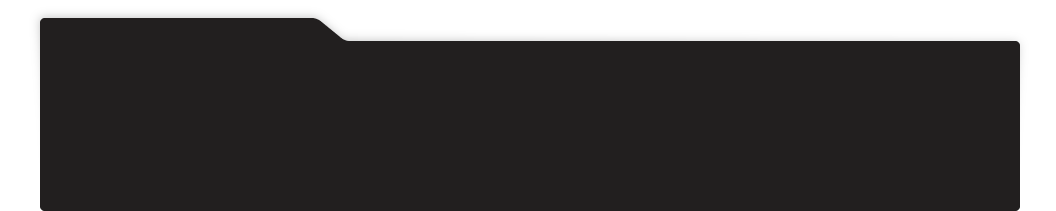
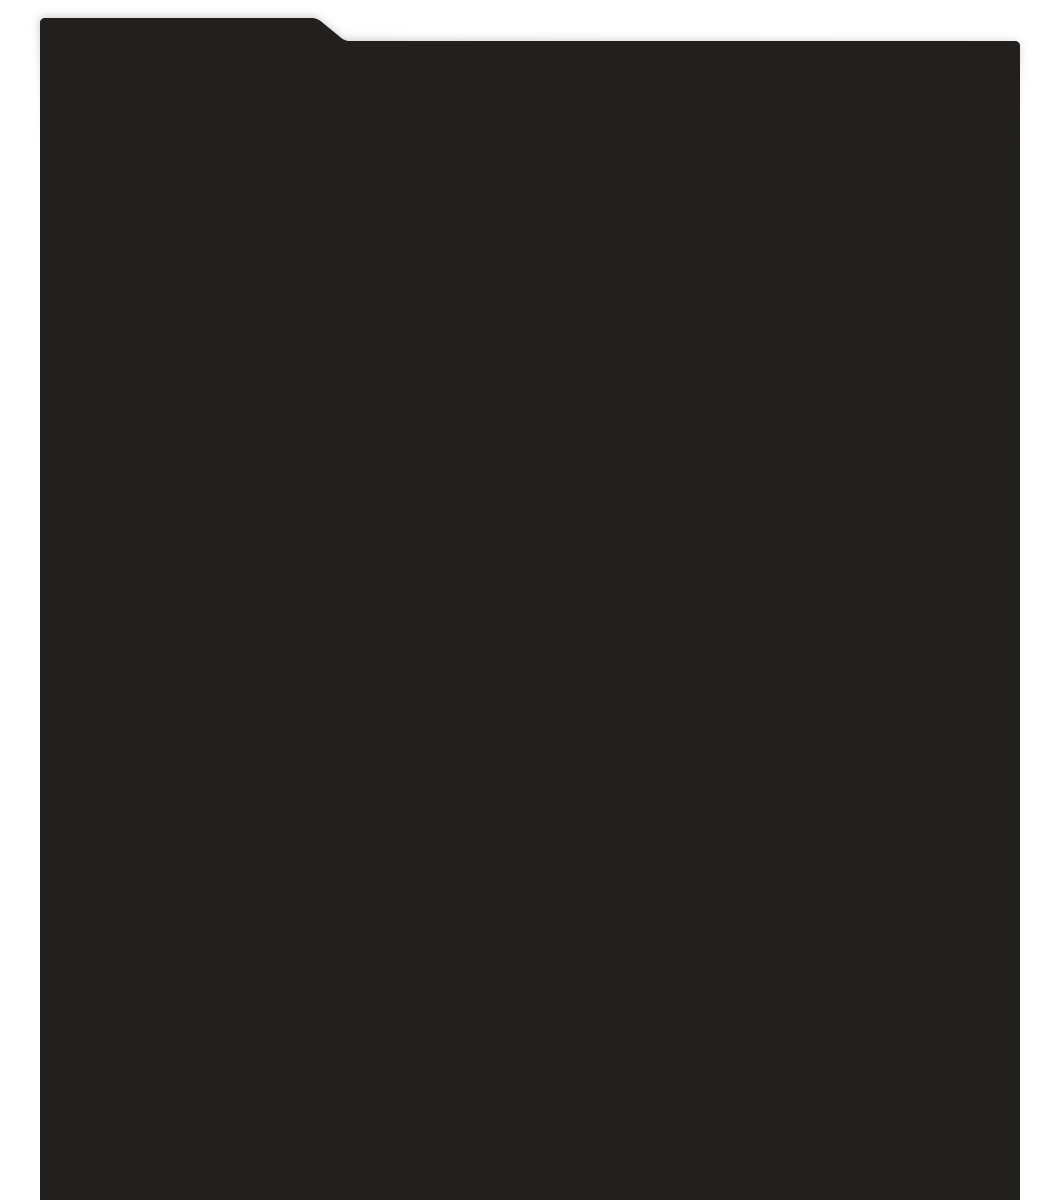
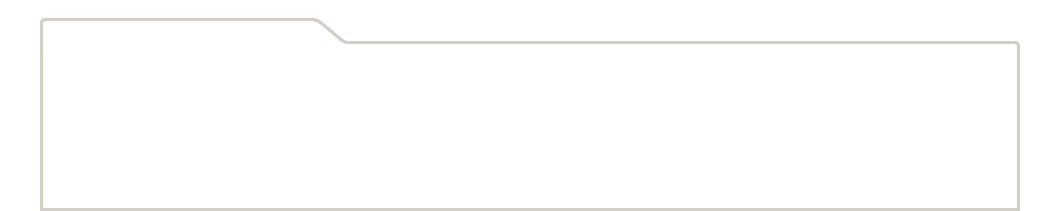
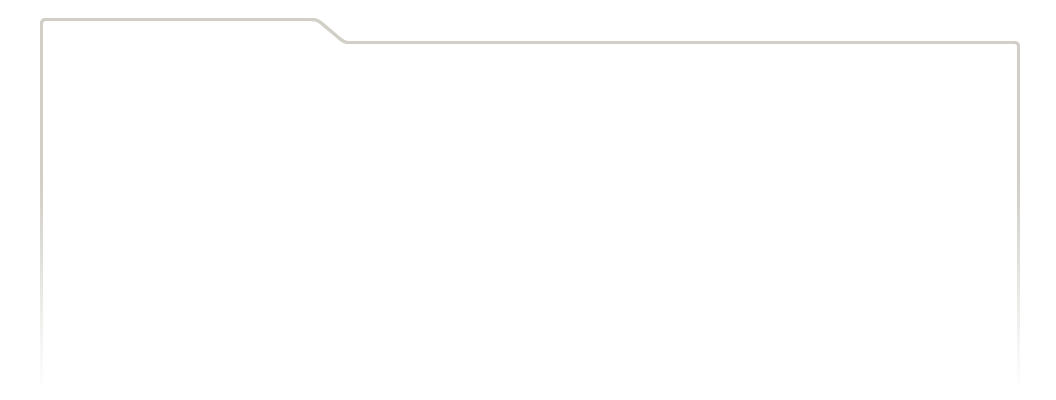
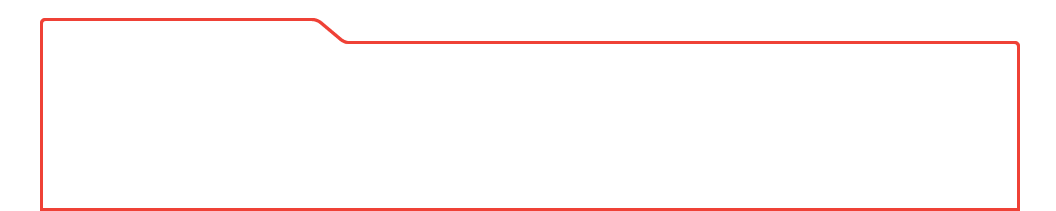
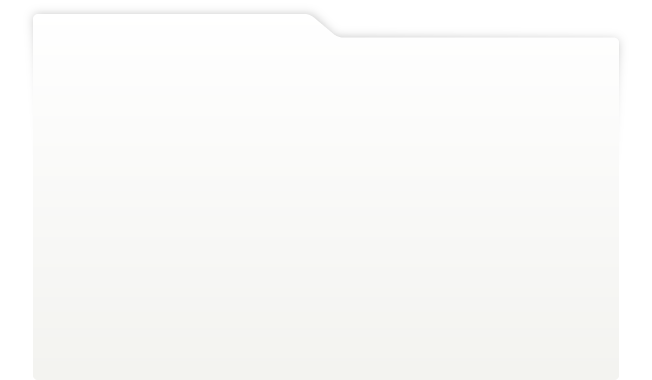
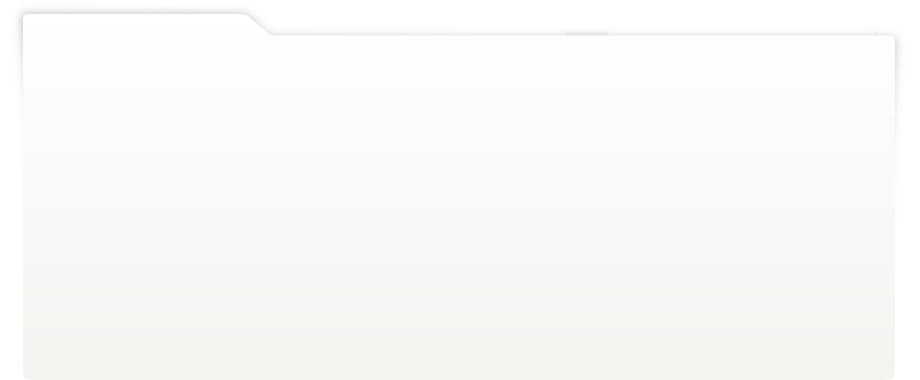
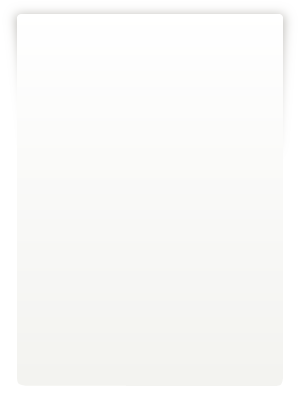
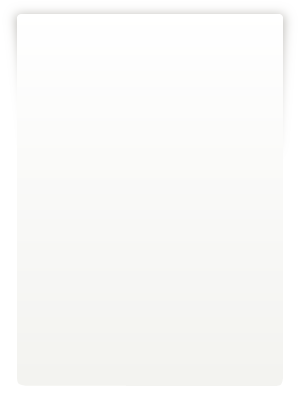
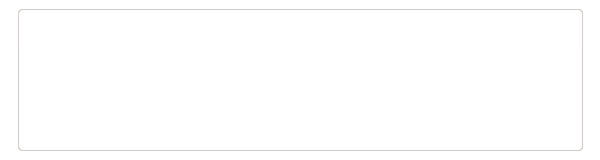
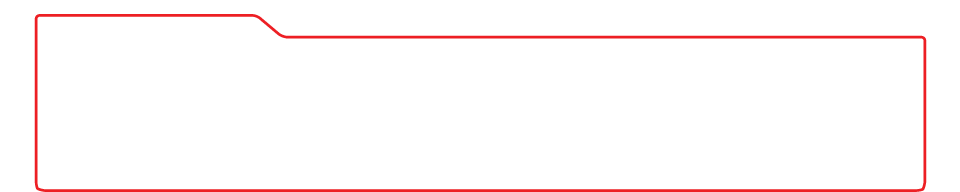
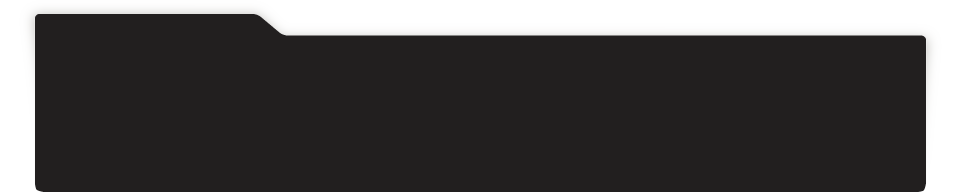
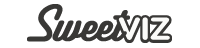
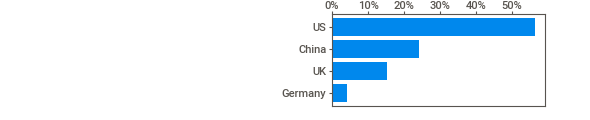
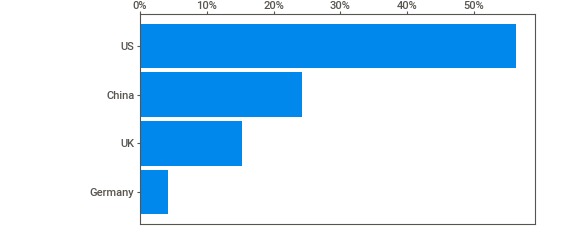
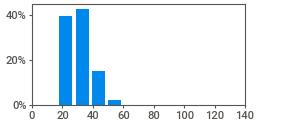
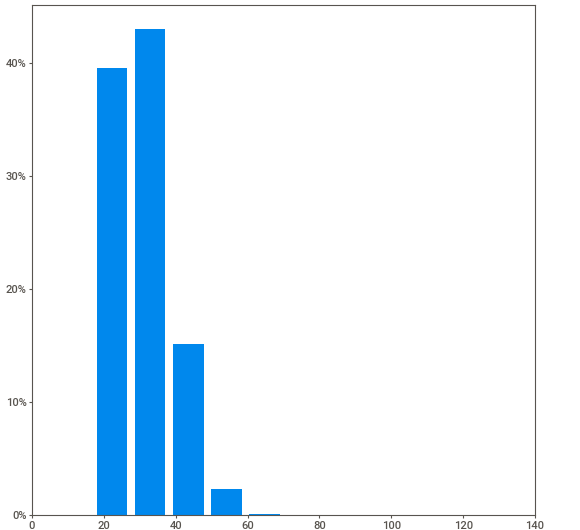
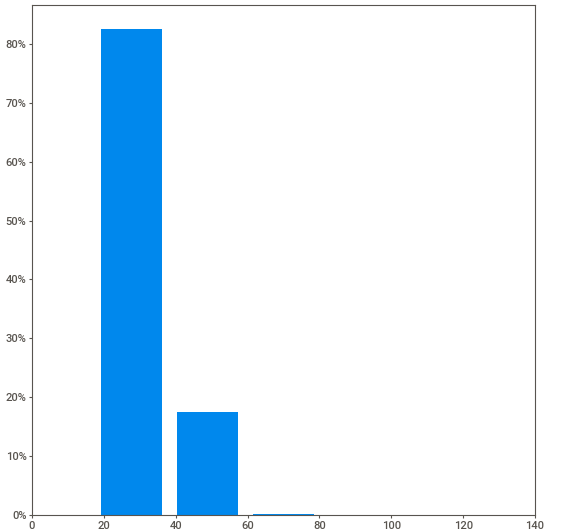
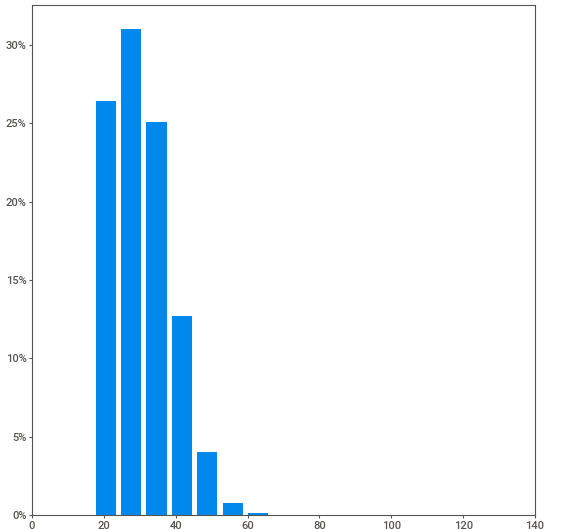
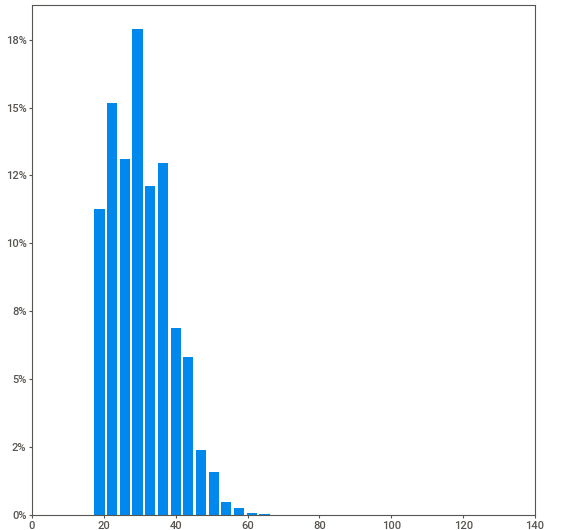
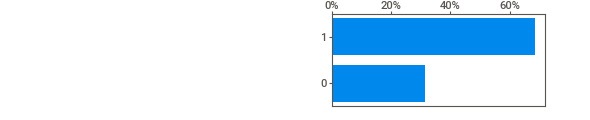
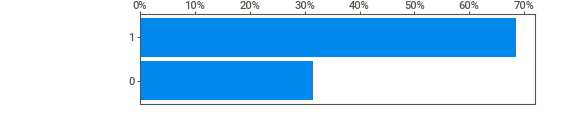
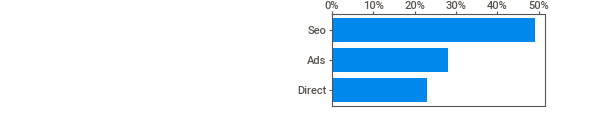
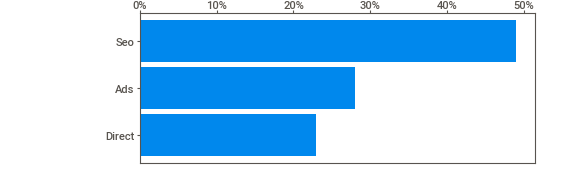
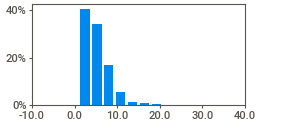
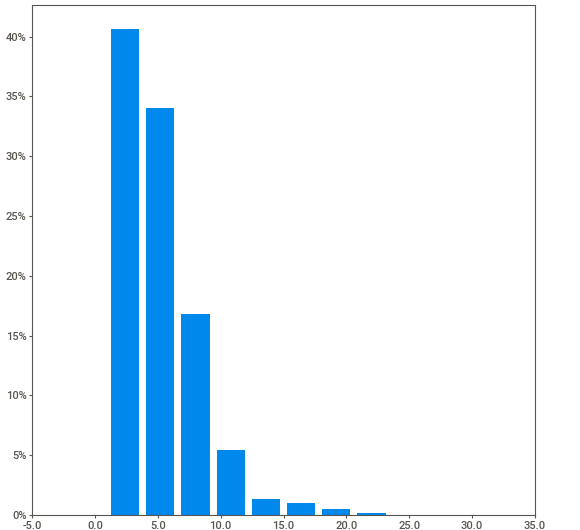
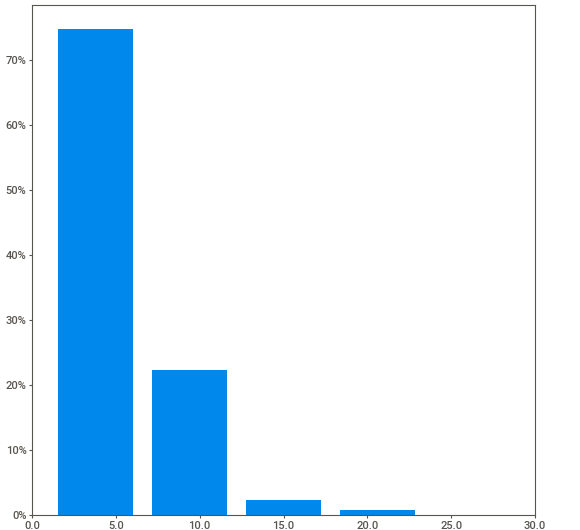
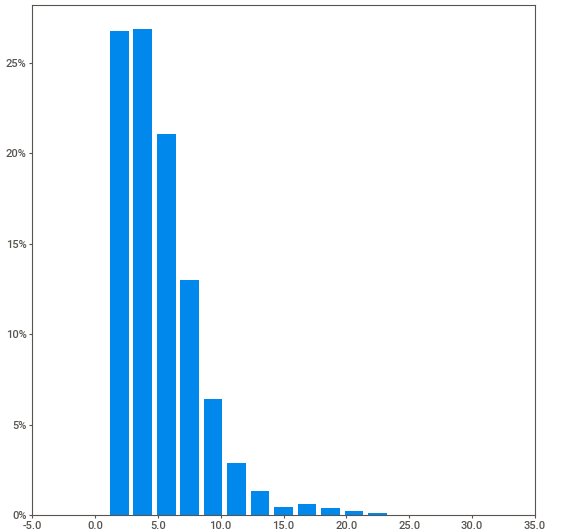
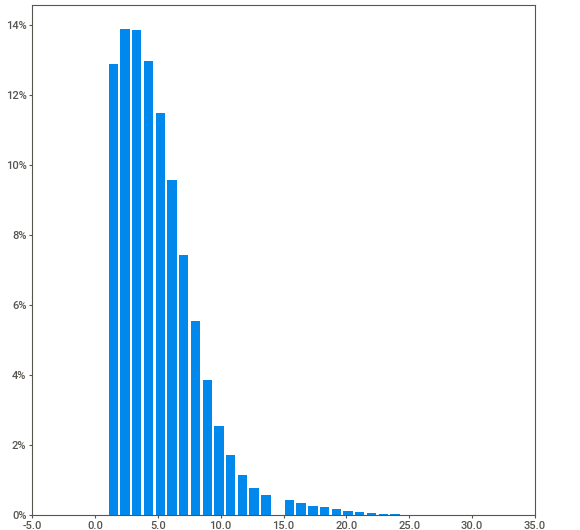
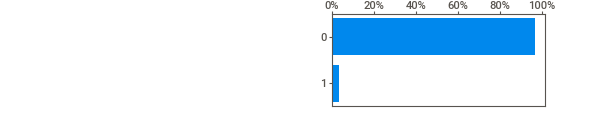
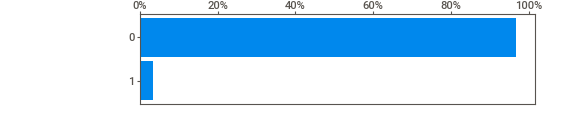
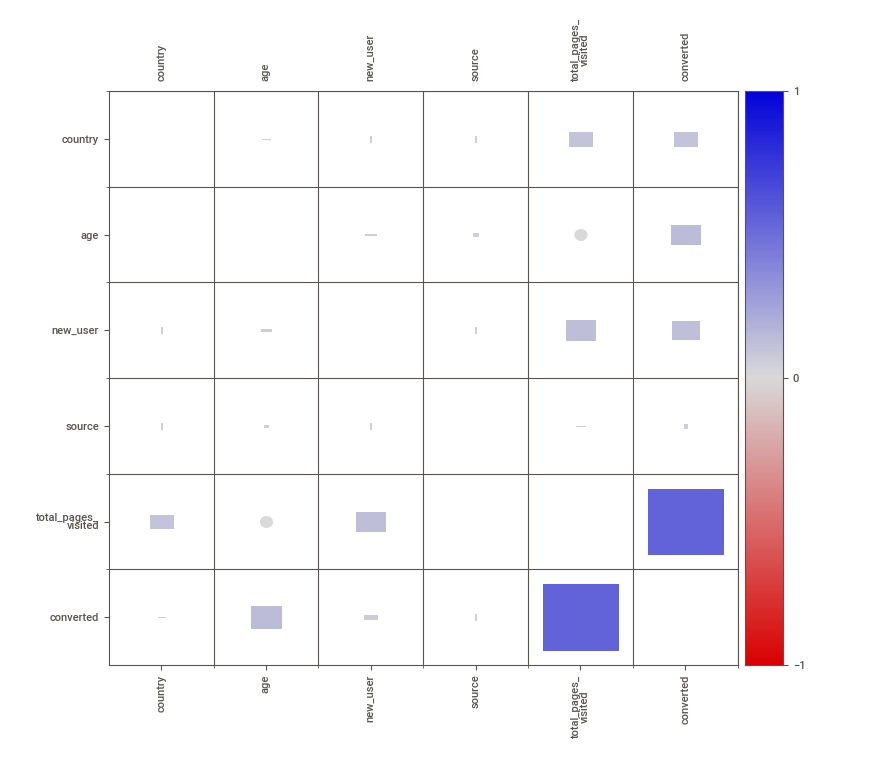
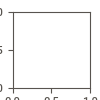

In [4]:
import sweetviz as sv
my_report = sv.analyze(data)
my_report.show_notebook()

# Data Precessing

From the data overview, we can find there are some users whose age are beyond 100. We should investigate how many outliers are there.

In [5]:
data[data['age'] >= 80] # use 80 instead of 100.

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


As there are ony two outliers, we can drop them directly.

In [6]:
data = data[data['age'] < 80] 

# Data Visualisation

Text(0.5, 1.0, 'conversion rate by age')

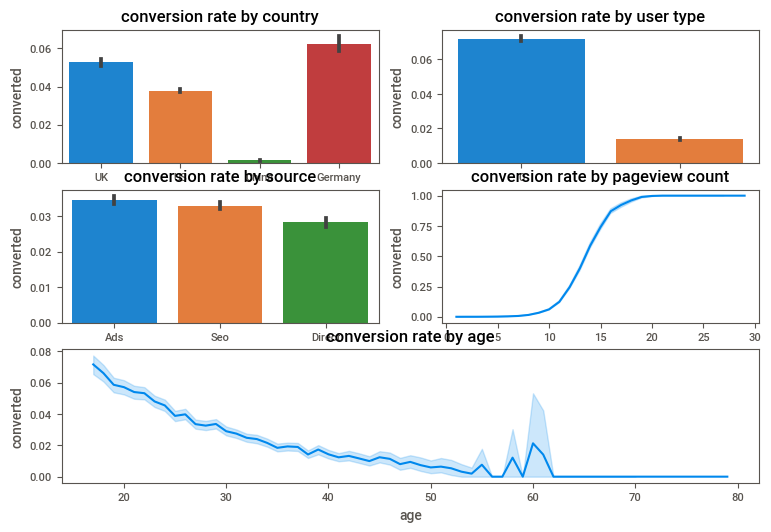

In [7]:
f = plt.figure(figsize=(9, 6))
f.add_subplot(3,2,1)
sns.barplot(x='country',y='converted', data=data).set_title('conversion rate by country')
f.add_subplot(3,2,2)
sns.barplot(x='new_user',y='converted', data=data).set_title('conversion rate by user type')
f.add_subplot(3,2,3)
sns.barplot(x='source',y='converted', data=data).set_title('conversion rate by source')
f.add_subplot(3,2,4)
sns.lineplot(x='total_pages_visited',y='converted', data=data).set_title('conversion rate by pageview count')
f.add_subplot(3,1,3)
sns.lineplot(x='age',y='converted', data=data).set_title('conversion rate by age')

# Modeling

## LableEcoder

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import tree
import pydotplus
from IPython.display import Image

In [10]:
label_cotr = LabelEncoder()
data['country'] = label_cotr.fit_transform(data['country'])
label_sorc = LabelEncoder()
data['source'] = label_sorc.fit_transform(data['source'])

C:\Users\CT\AppData\Local\Temp/ipykernel_8164/2088402463.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['country'] = label_cotr.fit_transform(data['country'])
C:\Users\CT\AppData\Local\Temp/ipykernel_8164/2088402463.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['source'] = label_sorc.fit_transform(data['source'])


## Data Split

In [11]:
x = data.drop(columns=['converted'])
y = data['converted']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

## Random Forest

In [12]:
model = RandomForestClassifier(criterion='entropy', 
                               max_depth=4, 
                               min_samples_leaf=2,
                               min_samples_split=3) # parameters here are after optimisation.
model.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=4, min_samples_leaf=2,
                       min_samples_split=3)

Comparing with default parameters, the optimised model improve the specificity by 4%.

## Metrics

##### Accuracy

In [13]:
y_pred = model.predict(x_test)
round(accuracy_score(y_test, y_pred),4)

0.9864

#####  Confusion Matrix

C:\Users\CT\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


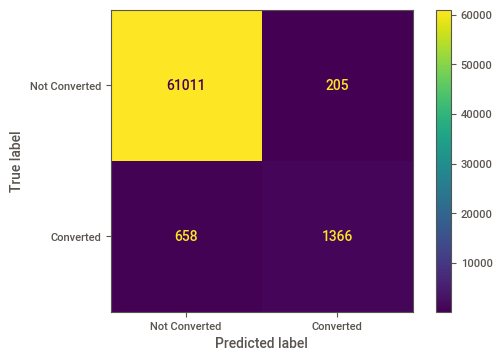

In [14]:
plot_confusion_matrix(model, 
                      x_test, 
                      y_test, 
                      values_format='d', 
                      display_labels=["Not Converted", "Converted"])

##### Classification Report

In [ ]:
print(classification_report(y_test, y_pred))

#####  ROC 

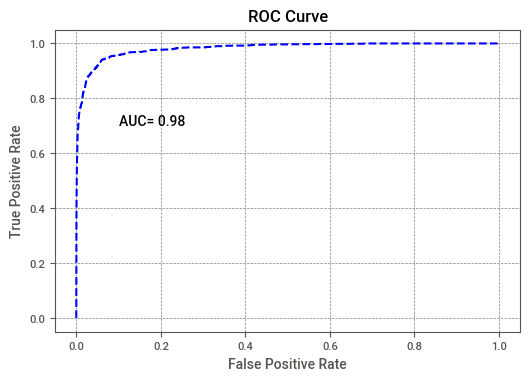

In [16]:
y_score = model.predict_proba(x_test)
y_score = y_score[:,1]
fpr, tpr, thresholds = roc_curve(y_test,y_score, pos_label=1)
plt.plot(fpr, tpr, linestyle = '--', c = "b")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve')
auc = round(roc_auc_score(y_test,y_score),2)
auc_result = "AUC= " +str(auc)
plt.text(0.1, 0.7, auc_result)
plt.show()

More attention should be given to "not converted", and therefore we need to optimise the model in order to improve the specificity of the model.

## Model Optimisation

As the dataset are too large, we only choose 2000 samples to optimise model.

In [ ]:
'''
param_grid = {
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2],
    'criterion':['entropy','gini']
}

optimal_params = GridSearchCV(
    estimator = RandomForestClassifier(),
    param_grid = param_grid,
    scoring = 'roc_auc', 
    verbose = 0,
)
optimal_params.fit(x_train.iloc[1:2000], y_train.iloc[1:2000])
optimal_params.best_params_
'''

## Tree Visualisation

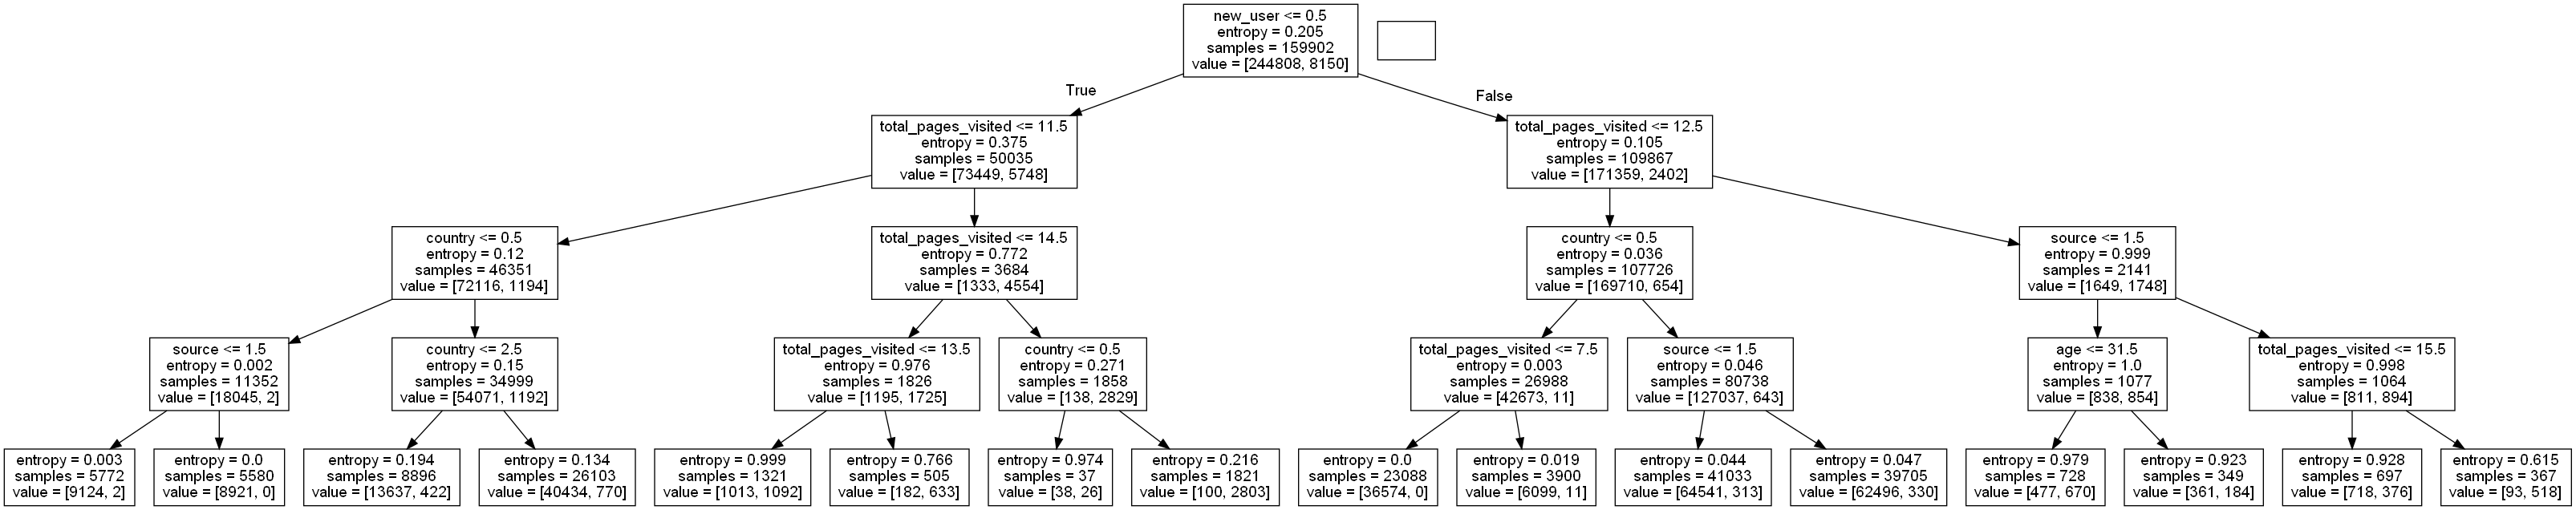

In [17]:
tree_viz = tree.export_graphviz(model.estimators_[0], out_file=None, feature_names=x_train.columns)
graph = pydotplus.graph_from_dot_data(tree_viz)
Image(graph.create_png())

##### Interpretation of a tree
1. Leaves with children show their splitting criterion on the top
2. The pair of values at the bottom show the count of False values 
and True values for the target respectively, of data points in that node of the tree.

## Feature Explainability

In [21]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import plot_partial_dependence
from pdpbox import pdp, get_dataset, info_plots

##### Feature Importance

<AxesSubplot:title={'center':'Feature Importance'}>

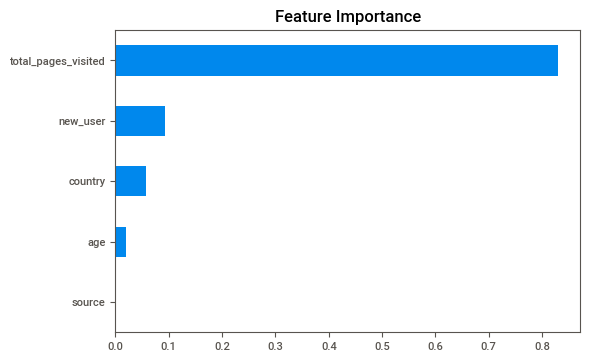

In [19]:
importance = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature = x_train.columns
importance.index = feature
importance.sort_values('importance', ascending=True, inplace=True)
importance.plot(kind='barh',legend=False, title='Feature Importance')

##### Perputation Importance

In [20]:
perm = PermutationImportance(model, random_state=2)
perm.fit(x_test, y_test)
eli5.show_weights(perm, feature_names = x_train.columns.tolist())

Weight,Feature
0.0334 ± 0.0006,total_pages_visited
0.0041 ± 0.0005,new_user
0.0039 ± 0.0002,country
0.0009 ± 0.0005,age
0.0001 ± 0.0001,source


##### Partial Dependence

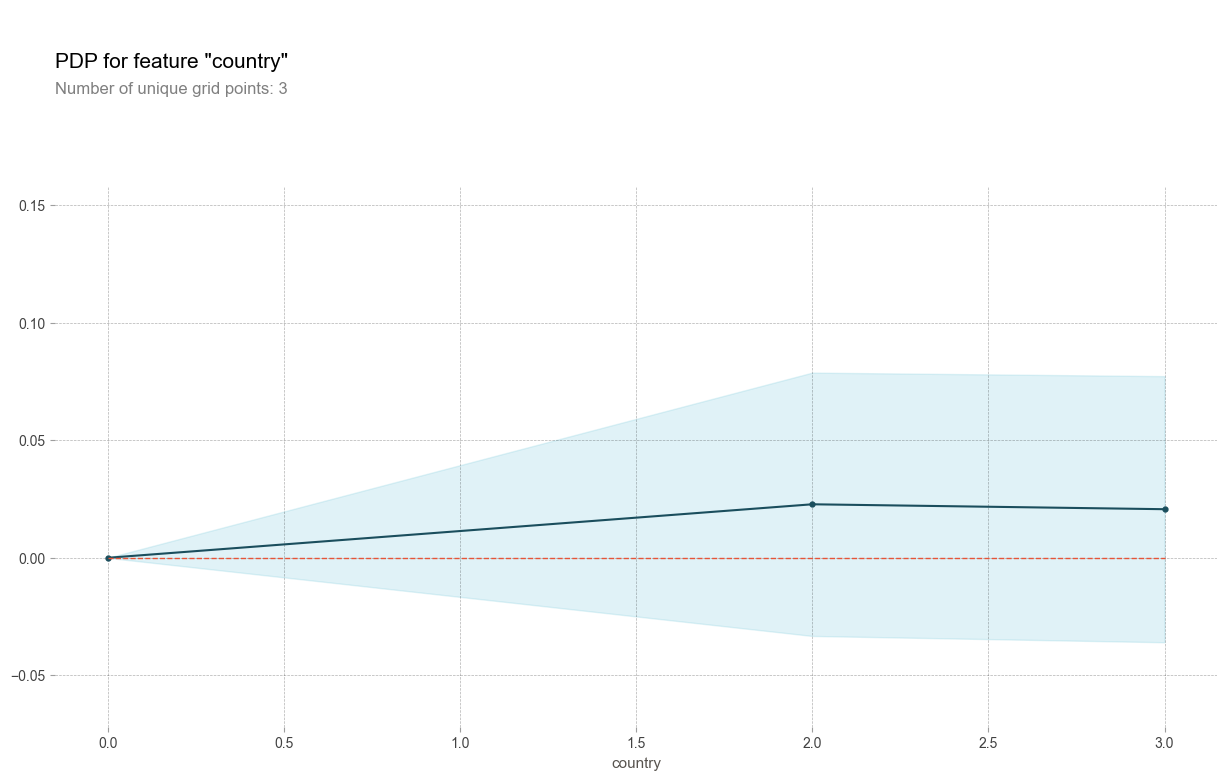

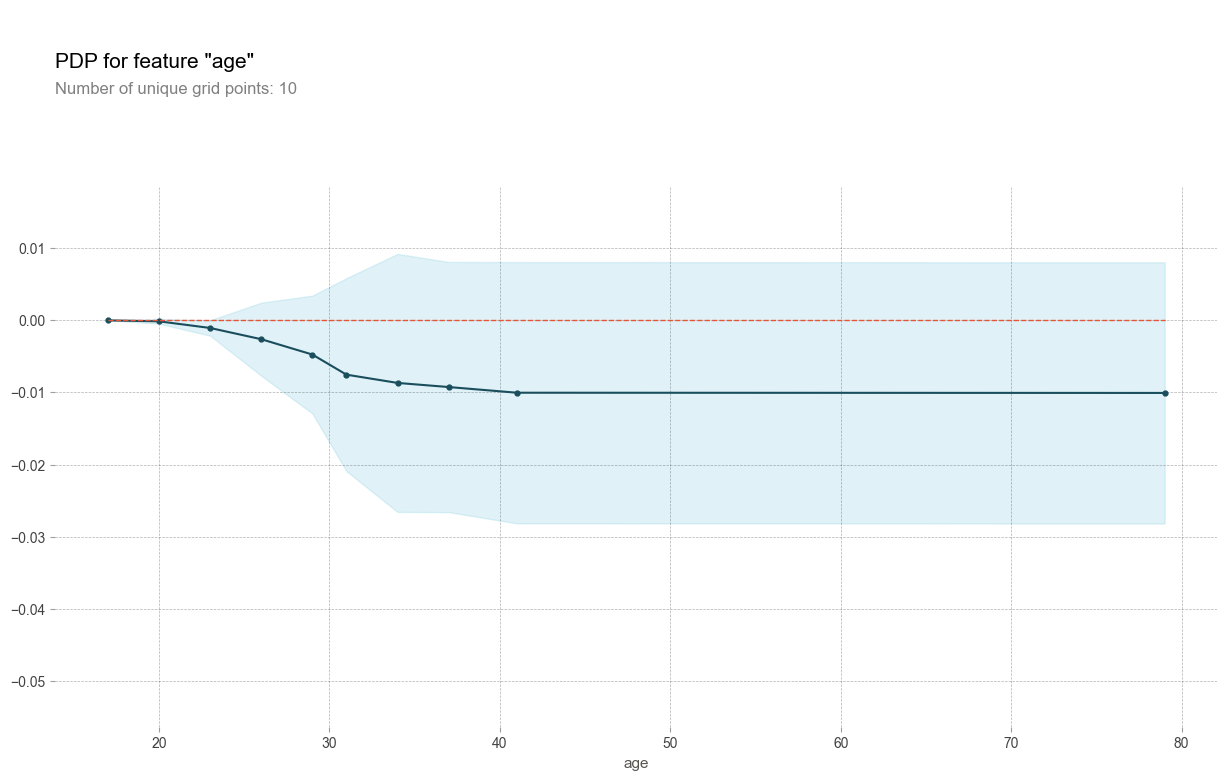

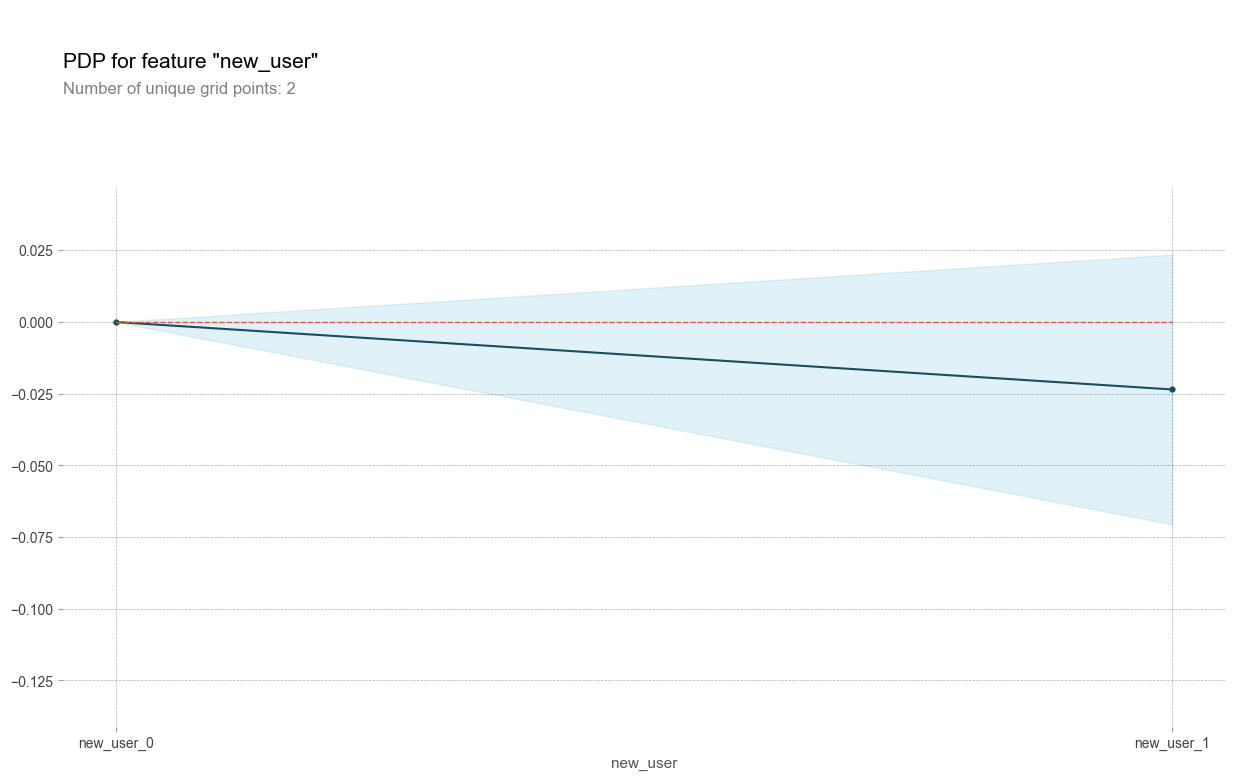

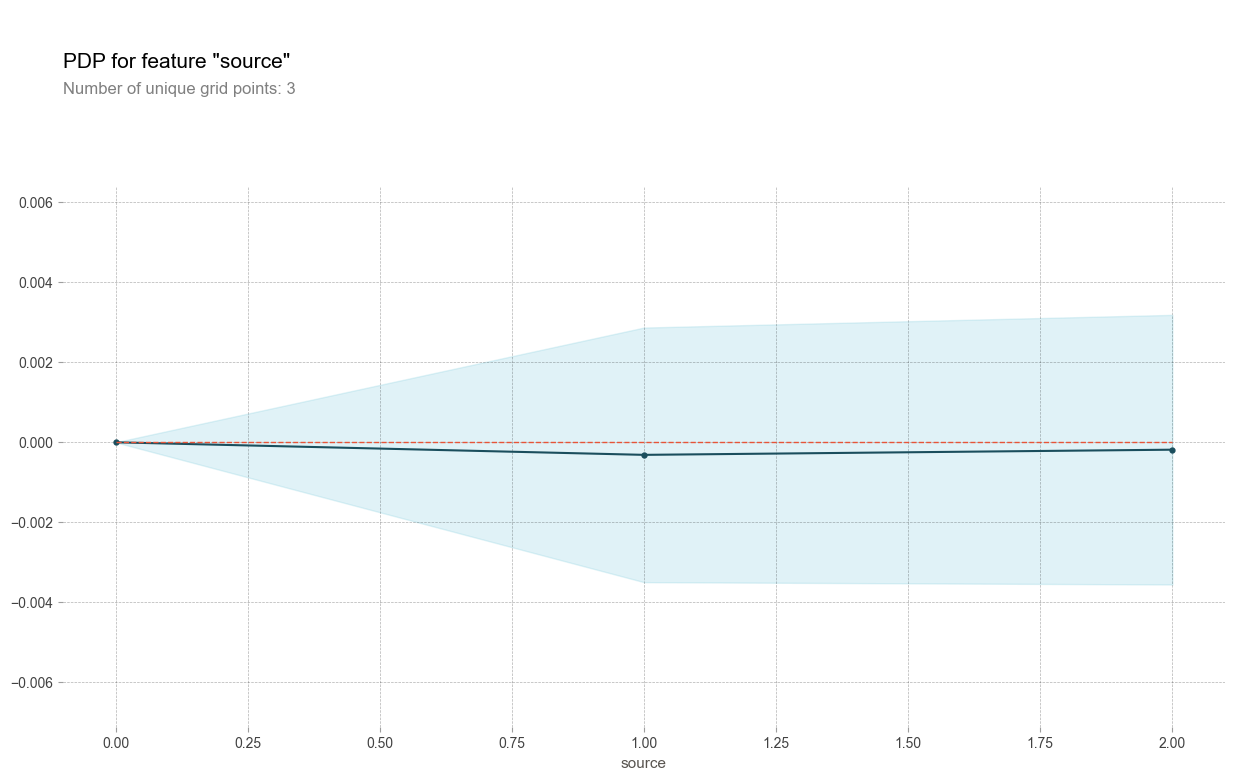

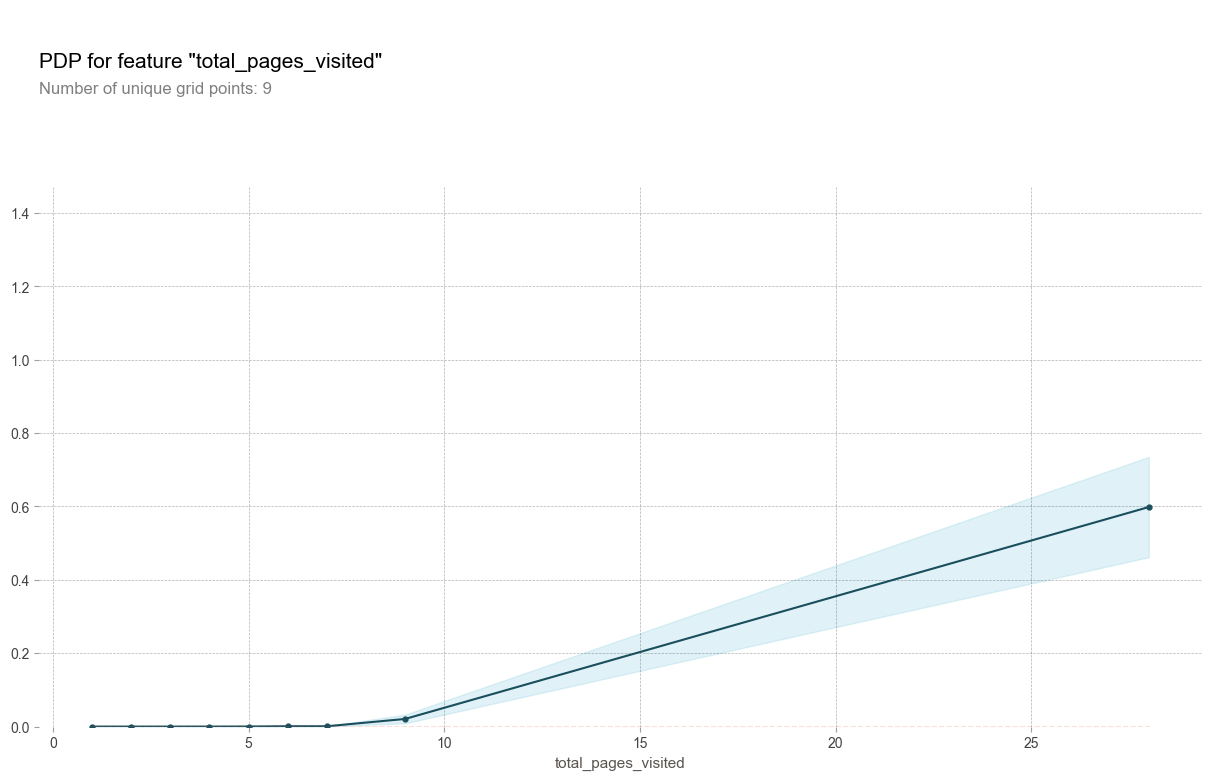

In [23]:
for name in x_train.columns:
    pdp_goals = pdp.pdp_isolate(model=model, dataset=x_test, model_features=x_train.columns, feature=name)
    pdp.pdp_plot(pdp_goals, name)
    plt.show()